<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [4.0 Process Analytics](https://jckantor.github.io/cbe30338-2021/04.00-Process-Analytics.html) | [Contents](toc.html) | [4.2 State Estimation](https://jckantor.github.io/cbe30338-2021/04.02-State-Estimation.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/04.01-Process-Historians.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/04.01-Process-Historians.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 4.1 Data/Process/Operational Historian

## 4.1.1 Introduction

### 4.1.1.1 Terminology

* **DCS**: Distributed Control System

* **Database**: An organized collection of data that is stored and accessed electronically. Databases are a major industry and one of the most significant technologies underpinning the modern global economy.

    * **Ralational database**: Data organized as linked collections of tables comprised of rows and columns. Structured Query Language (SQL) is a specialized language for writing and querying relational databases. 
    * **NoSQL database**: Typically organized as key-value pairs, NoSQL databases encompass a broad range of technologies used in modern web applications and extremely large scale databases.
    * **Time-series database**: Data organized in time series consisting of time-value pairs, often organized as traces, curves, or trends. Typically used in industrial applications.
    
    
* **[Data | Operational | Process] Historian**: A time-series database used to store and access operational process data. 

### 4.1.1.2 Major Vendors of Data Historians

Data historians is about a $1B/year market globally, poised to grow much larger with the emerging **Industrial Internet of Things (IIoT)** market.

* GE, IBM, Hitachi-ABB, Rockwell Automation, Emerson, Honeywell, Siemens, AVEVA, OSIsoft, ICONICS, Yokogawa, PTC, Inductive Automation, Canary Labs, Open Automation Software, InfluxData, Progea, Kx Systems, SORBA, Savigent Software, Automsoft, LiveData Utilities, Industrial Video & Control, Aspen Technology, and COPA-DATA

### 4.1.1.3 Example: OSIsoft PI System

* One of the market leaders is OSIsoft which markets their proprietary PI system. Founded in 1980, OSIsoft now has 1,400 employees and recently announced sale of the company for $5B to AVENA.

* The PI system is integrated suite of tools supporting the storage and retreival of process data in a time-series data base.

![](http://www.automatedresults.com/images/arpidiagram.png)



### 4.1.1.4 Process Analytics

Process analytics refers to analytical tools that use the data historian to provide usable information about the underlying processes. 

## 4.1.2 The tclab Data Historian

The tclab Python library support the Temperature Control Lab includes a very basic and no-frills implementation of a time-series data base. The purposes of the data historian are to 

* enable the collection and display of data durinig the course of developing control strategies, and
* enable post-experiment analysis using standard Python libraries such as Pandas.

Documentatiion is available for the tclab [Historian](https://tclab.readthedocs.io/en/latest/notebooks/05_TCLab_Historian.html) and associated [Plotter](https://tclab.readthedocs.io/en/latest/notebooks/06_TCLab_Plotter.html) modules.

Historian is implemented using [SQLite](https://www.sqlite.org/index.html), a small, self-contained SQL data system in the public domain. SQLite was originally developed in 2000 by D. Richard Hipp who was designing software for a damage-control systems used in the U.S. Navy aboard gui}ded missile destroyers. Since then it has become widely used in embedded systems including most laptops, smartphones, and browsers. If you used Apple photos, messaging on your smartphone, GPS units in your car, then you've used SQLite. It estimated there are over 1 trillion SQLite databases in active use. Much of the success is to due to the licensing terms (free!) and an extraordinarily level of automated code testing assuring a high level of reliability.

Below we will introduce useful capabilities of the Historian that will prove useful as we explore more sophisticated control algorithms and strategies.

* Data logging
* Acessing data

### 4.1.2.1 Data Logging

#### 4.1.2.1.1 Creating a log

In [4]:
from tclab import setup, clock, Historian

TCLab = setup(connected=False, speedup=60)

with TCLab() as lab:
    h = Historian(lab.sources)
    lab.Q1(100)
    for t in clock(600):
        h.update(t)

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


#### 4.1.2.1.2 Accessing Data using `.columns` and `.fields`

In [5]:
# columns property consists of all data being logged
h.columns

['Time', 'T1', 'T2', 'Q1', 'Q2']

In [6]:
# access data using fields
t, T1, T2, Q1, Q1 = h.fields

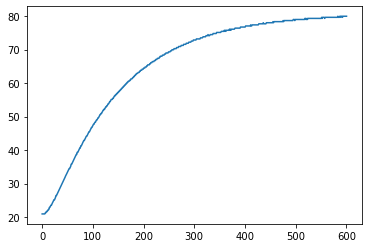

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(t, T1)

#### 4.1.2.1.3 Accessing Data by Name `logdict`

Sometimes you only need specific fields. You can access them directly by name using `.logdict[]` which is short for 'log dictionary'.

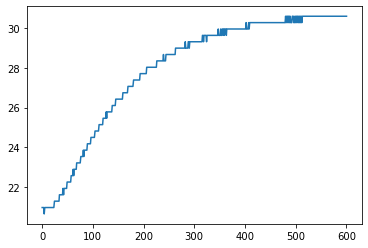

In [8]:
plt.plot(h.logdict["Time"], h.logdict["T2"])

#### 4.1.2.1.4 Accessing Data using `pandas`

The Python `pandas` library provides an enormous range of tools for data analysis. To access the historian data using pandas

<AxesSubplot:xlabel='Time'>

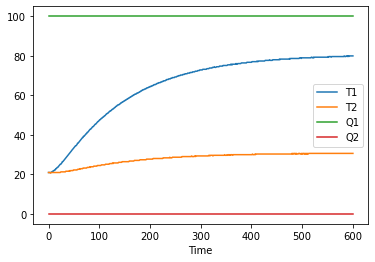

In [9]:
import pandas as pd
df = pd.DataFrame.from_records(h.log, columns=h.columns, index='Time')

df.plot()

#### 4.1.2.1.5 Saving to a file

In [10]:
h.to_csv("saved_data.csv")

### 4.1.2.2 Specifying sources

As we develop increasingly complex control algorthms, we will wish to record additional data during the course of an experiment. This is done by specifying data sources. Each source is defined by a `(tag, fcn)` pair where `tag` is string label for data, and `fcn` is a function with no arguments that returns a current value. An example is 

    ('Q1', lab.Q1)
    
where `Q1` is the tag, and `lab.Q1()` returns the current value of heater power reported by the hardware.
    

In [13]:
from tclab import setup, clock, Historian

# proportional control gain
Kp = 4.0

# setpoint function
def SP1(t):
    return 20.0 if t <= 100 else 50.0

TCLab = setup(connected=False, speedup=60)

with TCLab() as lab:
    # add setpoint to default sources
    sources = lab.sources
    sources.append(('SP1', lambda: SP1(t)))
    h = Historian(sources)
    for t in clock(600):
        U1 = Kp*(SP1(t) - lab.T1)
        lab.Q1(U1)
        h.update(t)

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


In [14]:
h.columns

['Time', 'T1', 'T2', 'Q1', 'Q2', 'SP1']

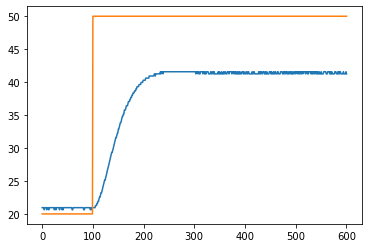

In [15]:
t, T1, T2, Q1, Q2, SP1 = h.fields
plt.plot(t, T1, t, SP1)

In [17]:
from tclab import setup, clock, Historian

# proportional control gain
Kp = 4.0

# setpoint function
def SP1(t):
    return 20.0 if t <= 100 else 50.0

# setpoint function
SP2 = 30.0

TCLab = setup(connected=False, speedup=60)

with TCLab() as lab:
    # add setpoint to default sources
    sources = lab.sources
    sources.append(('SP1', lambda: SP1(t)))
    sources.append(('SP2', lambda: SP2))
    h = Historian(sources)
    for t in clock(600):
        U1 = Kp*(SP1(t) - lab.T1)
        U2 = 100 if lab.T2 < SP2 else 0
        lab.Q1(U1)
        lab.Q2(U2)
        h.update(t)

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


In [18]:
h.columns

['Time', 'T1', 'T2', 'Q1', 'Q2', 'SP1', 'SP2']

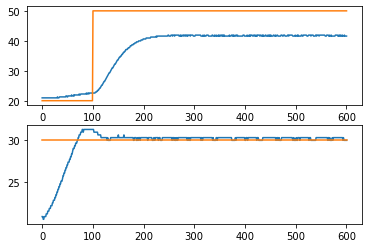

In [19]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(h.logdict["Time"], h.logdict["T1"], h.logdict["Time"], h.logdict["SP1"])
ax[1].plot(h.logdict["Time"], h.logdict["T2"], h.logdict["Time"], h.logdict["SP2"])


### 4.1.2.3 Persistence

In [20]:
from tclab import setup, clock, Historian

# proportional control gain
Kp = 4.0

# setpoint function
def SP1(t):
    return 20.0 if t <= 100 else 50.0

# setpoint function
SP2 = 40.0

TCLab = setup(connected=False, speedup=60)

with TCLab() as lab:
    # add setpoint to default sources
    sources = lab.sources
    sources.append(('SP1', lambda: SP1(t)))
    sources.append(('SP2', lambda: SP2))
    h = Historian(sources, dbfile="lab4.db")
    for t in clock(600):
        U1 = Kp*(SP1(t) - lab.T1)
        U2 = 100 if lab.T2 < SP2 else 0
        lab.Q1(U1)
        lab.Q2(U2)
        h.update(t)

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


In [41]:
h.get_sessions()

[(1, '2021-03-16 13:49:57', 600), (2, '2021-03-16 13:51:04', 597)]

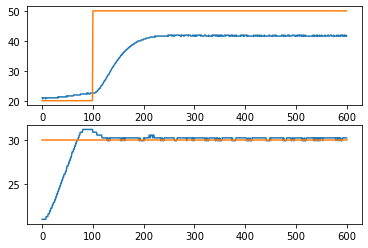

In [45]:
h.load_session(1)
fig, ax = plt.subplots(2, 1)

ax[0].plot(h.logdict["Time"], h.logdict["T1"], h.logdict["Time"], h.logdict["SP1"])
ax[1].plot(h.logdict["Time"], h.logdict["T2"], h.logdict["Time"], h.logdict["SP2"])

In [49]:
g = Historian([], dbfile="lab4.db")
g.get_sessions()

[(1, '2021-03-16 13:53:36', 599), (2, '2021-03-16 13:53:53', 0)]

## 4.1.3 Plotter

The `Plotter` class provides a real-time graphical interface to an historian. It provides some simple facilities for 

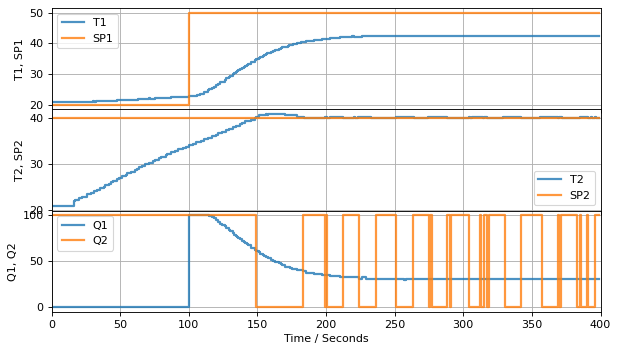

TCLab Model disconnected successfully.


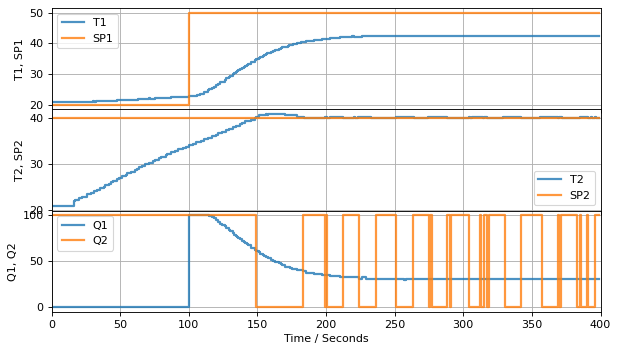

In [24]:
from tclab import setup, clock, Historian, Plotter

# proportional control gain
Kp = 4.0

# setpoint function
def SP1(t):
    return 20.0 if t <= 100 else 50.0

# setpoint function
SP2 = 40.0

TCLab = setup(connected=False, speedup=60)

with TCLab() as lab:
    # add setpoint to default sources
    sources = lab.sources
    sources.append(['SP1', lambda: SP1(t)])
    sources.append(['SP2', lambda: SP2])
    h = Historian(sources, dbfile="lab4.db")
    
    layout = [["T1", "SP1"], ["T2", "SP2"], ["Q1", "Q2"]]
    p = Plotter(h, 400, layout)
    for t in clock(400):
        U1 = Kp*(SP1(t) - lab.T1)
        U2 = 100 if lab.T2 < SP2 else 0
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)

In [25]:
h.get_sessions()

[(1, '2021-03-16 13:53:36', 599),
 (2, '2021-03-16 13:53:53', 0),
 (3, '2021-03-16 13:56:20', 597),
 (4, '2021-03-16 13:56:50', 0),
 (5, '2021-03-16 13:56:57', 599),
 (6, '2021-03-16 13:57:08', 459),
 (7, '2021-03-16 14:47:56', 84),
 (8, '2021-03-16 14:48:24', 296),
 (9, '2021-03-16 14:50:42', 12),
 (10, '2021-03-16 14:51:05', 8),
 (11, '2021-03-16 14:52:10', 39),
 (12, '2021-03-16 14:52:23', 66),
 (13, '2021-03-16 14:52:47', 0),
 (14, '2021-03-16 14:52:59', 0),
 (15, '2021-03-16 14:56:40', 594),
 (16, '2021-03-16 14:59:18', 0),
 (17, '2021-03-16 15:02:16', 95),
 (18, '2021-03-16 15:03:02', 295)]

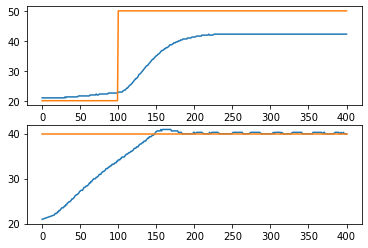

In [26]:

fig, ax = plt.subplots(2, 1)

ax[0].plot(h.logdict["Time"], h.logdict["T1"], h.logdict["Time"], h.logdict["SP1"])
ax[1].plot(h.logdict["Time"], h.logdict["T2"], h.logdict["Time"], h.logdict["SP2"])

<!--NAVIGATION-->
< [4.0 Process Analytics](https://jckantor.github.io/cbe30338-2021/04.00-Process-Analytics.html) | [Contents](toc.html) | [4.2 State Estimation](https://jckantor.github.io/cbe30338-2021/04.02-State-Estimation.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/04.01-Process-Historians.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/04.01-Process-Historians.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>